### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70101: Audi <br>
    3530203_70102: BMW <br>
    3530903_70301: Ford <br>
    3530903_70302: Mercedes<br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Попытаться обучить регрессии c лучшим качеством. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xg

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split

In [2]:
ad = pd.read_csv("bmw.csv")

### Смотрим на данные

In [3]:
ad.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


### Посмотрим, есть ли пропущенные значения

In [5]:
ad.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

### Может есть скрытые пропуски?

In [6]:
ad['model'].value_counts()

 3 Series    2443
 1 Series    1969
 2 Series    1229
 5 Series    1056
 4 Series     995
 X1           804
 X3           551
 X5           468
 X2           288
 X4           179
 M4           125
 Z4           108
 6 Series     108
 7 Series     106
 X6           106
 X7            55
 i3            43
 8 Series      39
 M5            29
 M3            27
 M2            21
 i8            17
 M6             8
 Z3             7
Name: model, dtype: int64

In [7]:
ad['transmission'].value_counts()

Semi-Auto    4666
Automatic    3588
Manual       2527
Name: transmission, dtype: int64

In [8]:
ad['fuelType'].value_counts()

Diesel      7027
Petrol      3417
Hybrid       298
Other         36
Electric       3
Name: fuelType, dtype: int64

D:\programms\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'исследование')

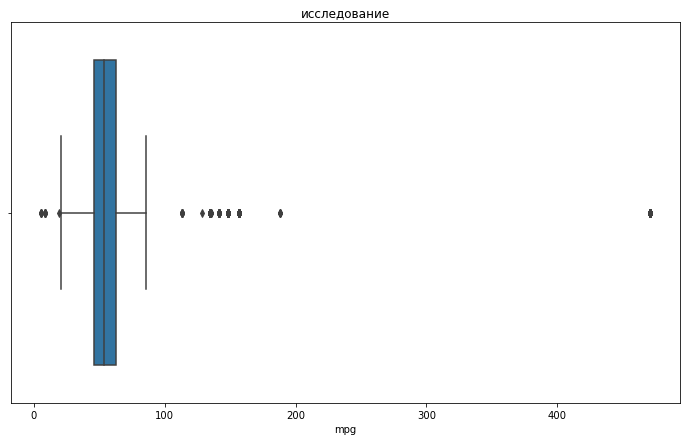

In [6]:
plt.subplots(figsize=(12,7))
sns.boxplot(ad['mpg'])
plt.title('исследование')

In [10]:
len(ad['mpg'][ad['mpg'] > 400])
ad[ad['mpg'] > 400].head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
32,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
621,i3,2017,19998,Automatic,41949,Hybrid,140,470.8,0.0
778,i3,2017,19998,Automatic,41146,Hybrid,0,470.8,0.0
780,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0
1866,i3,2017,19980,Automatic,26965,Hybrid,140,470.8,0.0


### Но если заметить, то все в порядке, это все принадлежит модели i3

### Посмотрим хитмап

<AxesSubplot:>

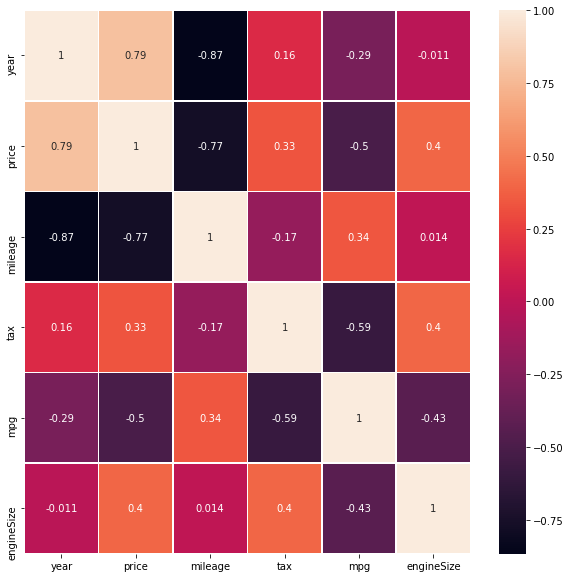

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ad.corr(method='spearman'), annot = True, linewidths=0.7, ax=ax )

### Второй вариант, но concat очень плохо работает...

In [3]:
X, Y = ad.drop(['price'], axis=1), ad['price']

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [27]:
X_train, X_nominal_train = X_train.drop(columns=['model', 'transmission', 'fuelType'], axis=1), X_train[['model', 'transmission', 'fuelType']]
X_test, X_nominal_test = X_test.drop(columns=['model', 'transmission', 'fuelType'], axis=1), X_test[['model', 'transmission', 'fuelType']]

In [28]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [33]:
X_train_scaled =pd.DataFrame(X_train_scaled)

In [36]:
print(X_train_scaled.shape)
X_train_scaled.head()

(7546, 5)


,0,1,2,3,4
0,-0.881915,1.214674,-1.629165,0.210562,-0.306889
1,0.394851,-0.557262,0.297065,-0.498119,1.508416
2,0.820440,-0.919036,0.216805,-0.478703,-1.214542
3,0.820440,-0.308110,0.216805,-0.245712,-0.306889
4,0.394851,-0.667113,0.216805,-0.734346,1.508416


In [29]:
X_nominal_train = pd.get_dummies(data=X_nominal_train, columns=['model','transmission','fuelType'])
X_nominal_test = pd.get_dummies(data=X_nominal_test, columns=['model','transmission','fuelType'])

In [30]:
print(X_nominal_train.shape)
X_nominal_train.head()

(7546, 31)


,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,model_ M2,model_ M3,...,model_ Z4,model_ i3,model_ i8,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
1934,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
5392,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2480,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
6215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [18]:
X_train = pd.concat([pd.DataFrame(X_train_scaled),X_nominal_train],axis = 1)
X_test = pd.concat([pd.DataFrame(X_test_scaled),X_nominal_test],axis = 1)

In [40]:
pd.concat([X_train_scaled,X_nominal_train],axis = 1,ignore_index=True).shape

(9842, 36)

In [19]:
X_train

,0,1,2,3,4,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,...,model_ Z4,model_ i3,model_ i8,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,-0.881915,1.214674,-1.629165,0.210562,-0.306889,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.394851,-0.557262,0.297065,-0.498119,1.508416,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.820440,-0.919036,0.216805,-0.478703,-1.214542,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.820440,-0.308110,0.216805,-0.245712,-0.306889,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.394851,-0.667113,0.216805,-0.734346,1.508416,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10775,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10777,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10778,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10779,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Создаем пайплайн
по документации [отсюда](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [4]:
numeric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['model', 'transmission', 'fuelType']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Строим пайплайн
Взяли xgboost [отсюда](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
А также использовали [grid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
<br><b>Ниже остальные алгоритмы</b>

In [14]:

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GridSearchCV(xg.XGBRegressor(objective ='reg:squarederror', seed = 10), 
                                                  param_grid={'n_estimators': np.arange(10, 100, 5),
                                                             'reg_alpha' : np.arange(0, .5, 0.1),
                                                             'reg_lambda' : np.arange(0, .5, 0.1)},
                        scoring='r2', cv=5)) ])

### Разбиваем датасет

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [16]:
clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'mileage', 'tax',
                                                   'mpg', 'engineSize']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['model', 'transmission',
                                                   'fuelType'])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=...
                        

In [17]:
print("model score: %.3f" % clf.score(X_test, Y_test))

model score: 0.956


In [18]:
from sklearn.metrics import mean_squared_error as MSE

y_pred = clf.predict(X_test)
np.sqrt(MSE(Y_test, y_pred))

2350.9131987909564

In [20]:
clf.steps[1][1].best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=85, n_jobs=8, num_parallel_tree=1, random_state=10,
             reg_alpha=0.0, reg_lambda=0.4, scale_pos_weight=1, seed=10,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [22]:
clf.steps[1][1].estimator

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=10, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [21]:
clf.steps[1][1].best_score_

0.9421488953609505

#### по итогу grid можно построить такую регрессию через xgboost с такими характеристиками

In [23]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 85, reg_lambda = 0.4, seed = 10) )])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))
from sklearn.metrics import mean_squared_error as MSE
y_pred = clf.predict(X_test)
print(np.sqrt(MSE(Y_test, y_pred)))

model score: 0.956
2350.9131987909564


#### а можно и такую

In [25]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 90, seed = 123) )])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))
from sklearn.metrics import mean_squared_error as MSE
y_pred = clf.predict(X_test)
print(np.sqrt(MSE(Y_test, y_pred)))

model score: 0.957
2337.728408279064


### LinearRegression

In [12]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))
from sklearn.metrics import mean_squared_error as MSE

y_pred = clf.predict(X_test)
print(np.sqrt(MSE(Y_test, y_pred)))

model score: 0.882
3870.3025855100846


### RidgeCV

In [13]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeCV())])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))
from sklearn.metrics import mean_squared_error as MSE

y_pred = clf.predict(X_test)
print(np.sqrt(MSE(Y_test, y_pred)))

model score: 0.882
3871.710957676267
